# 2025 Pocono Monte Carlo Simulation

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
import requests
from PIL import Image
from io import BytesIO
from collections import Counter

In [4]:
cup_roster = pd.read_csv("https://raw.githubusercontent.com/jake-lukasik/NASCAR-Race-Predictions/refs/heads/main/Master-Data/2025-cup-series-full-timers.txt")

In [5]:
simulation_data = pd.read_csv("https://raw.githubusercontent.com/jake-lukasik/NASCAR-Race-Predictions/main/Pocono-Driver-Data/pocono-sim-ready-data.csv")
simulation_data.head()

,Unnamed: 0,Driver,Avg Finish,Races,Wins,Top 5's,Top 10's,Laps Led,DNF,Avg Rating,DNF_Prob,Laps Led Per Race,Std Dev
0,0,William Byron,9.4,11,0,3,6,130,0,96.7,0.030000,11.818182,2.5
1,1,Brad Keselowski,10.8,27,1,11,16,247,1,94.4,0.037037,9.148148,2.5
2,2,Denny Hamlin,11.3,35,7,16,23,858,3,108.7,0.085714,24.514286,2.5
3,3,Kyle Larson,11.6,17,0,5,9,158,0,95.8,0.030000,9.294118,2.5
4,5,Ryan Blaney,13.4,15,2,3,7,95,1,89.6,0.066667,6.333333,3.5


In [6]:
def simulate_race(df):
    finish_positions = []
    
    for _, row in df.iterrows():
        # calculate a performance bonus to add a weight to drivers who have performed well
        # at track in categories other than avg. finish
        performance_bonus = (
            0.50 * row['Wins'] +
            0.10 * row['Laps Led Per Race'] +
            0.05 * row['Avg Rating']
        )

        # Apply bonus: decrease average finish (but not below 1)
        adjusted_avg_finish = max(1, row['Avg Finish'] - performance_bonus * 0.25)

        # quick check for a DNF
        dnf = np.random.rand() < row['DNF_Prob']
        
        if dnf:
            # DNF finish at the back of the pack
            finish_pos = np.random.randint(len(df) + 1, len(df) + 6)
        else:
            # Finished race: sample finish from a normal distribution centered at the
            # adjusted average finish location we found earlier (help incorporate things like wins)
            # use the std dev calculated from avg finish to control variability
            finish_pos = np.random.normal(loc=adjusted_avg_finish, scale=row['Std Dev'])
            
            # bound finish position between 1 and number of drivers so we get nothing crazy
            finish_pos = max(1, min(len(df), finish_pos))
        
        finish_positions.append((row['Driver'], finish_pos, dnf))
    
    # convert the list to a dataframe to sort and view easier
    results = pd.DataFrame(finish_positions, columns=['Driver', 'Finish_Pos', 'DNF'])
    
    # sort by DNF first (non-DNF comes first), then finish position
    results = results.sort_values(by=['DNF', 'Finish_Pos'], ascending=[True, True]).reset_index(drop=True)
    
    # driver in position 0 is the winner of that simulation
    winner = results.iloc[0]['Driver']
    return winner

def run_simulations(df, num_simulations=10000):
    win_counts = {driver: 0 for driver in df['Driver']}
    
    for i in range(num_simulations):
        winner = simulate_race(df)
        win_counts[winner] += 1
    
    # convert the list to a dataframe to sort and view easier
    win_probs = pd.DataFrame(list(win_counts.items()), columns=['Driver', 'Wins'])
    win_probs['Win_Prob'] = win_probs['Wins'] / num_simulations
    win_probs = win_probs.sort_values(by='Win_Prob', ascending=False).reset_index(drop=True)
    return win_probs

In [7]:
# run the simulation
results = run_simulations(simulation_data)
print(results)

                  Driver  Wins  Win_Prob
0          William Byron  3071    0.3071
1           Denny Hamlin  2178    0.2178
2        Brad Keselowski  1420    0.1420
3            Kyle Larson   790    0.0790
4            Ryan Blaney   570    0.0570
5          Chase Elliott   499    0.0499
6          Tyler Reddick   445    0.0445
7             Erik Jones   428    0.0428
8             Kyle Busch   110    0.0110
9       Christopher Bell    78    0.0078
10              Ty Gibbs    71    0.0071
11         Daniel Suarez    60    0.0060
12         Austin Dillon    51    0.0051
13           Joey Logano    46    0.0046
14           Alex Bowman    39    0.0039
15         Bubba Wallace    37    0.0037
16        Carson Hocevar    26    0.0026
17        Chris Buescher    25    0.0025
18         Chase Briscoe    20    0.0020
19            Josh Berry    19    0.0019
20   Ricky Stenhouse Jr.     7    0.0007
21     A.J. Allmendinger     6    0.0006
22             Ty Dillon     2    0.0002
23        Austin

C:\Users\jakel\AppData\Local\Temp\ipykernel_21096\1306530603.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results, x='Win_Prob', y='Driver', palette='viridis')


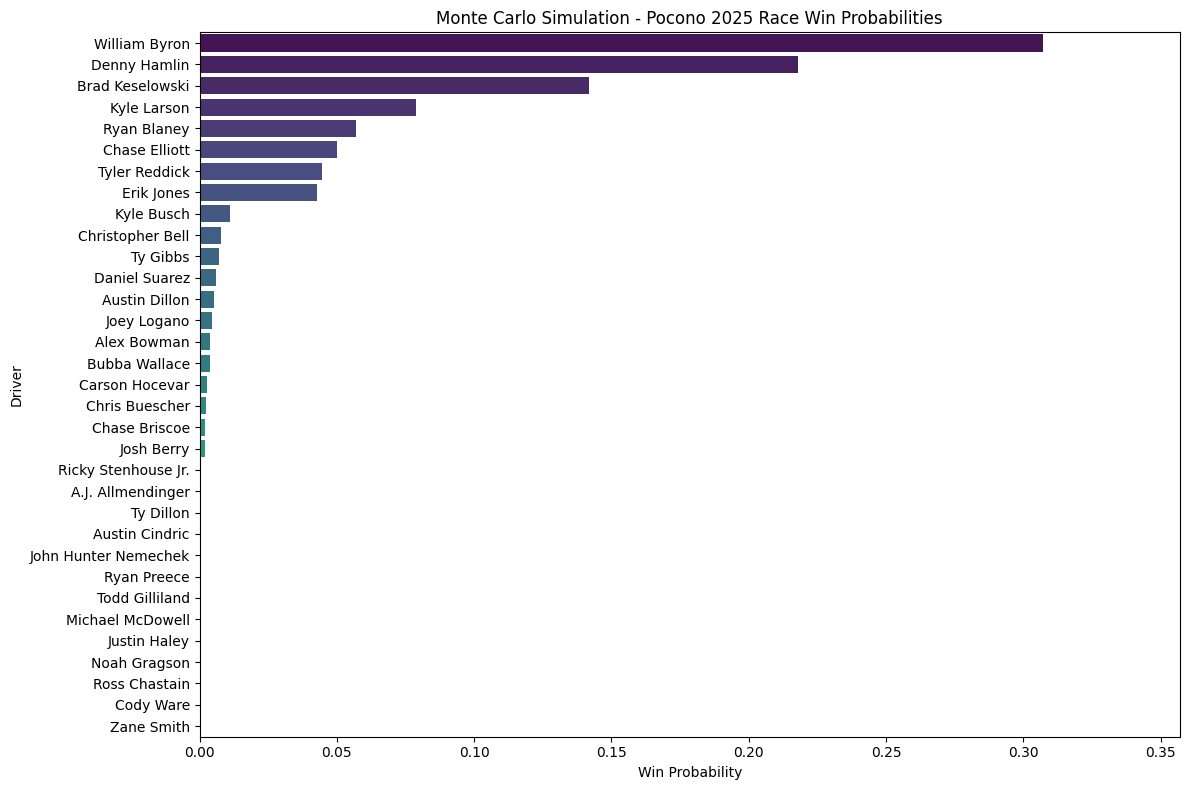

In [8]:
plt.figure(figsize=(12, 8))
sns.barplot(data=results, x='Win_Prob', y='Driver', palette='viridis')

plt.xlabel('Win Probability')
plt.ylabel('Driver')
plt.title('Monte Carlo Simulation - Pocono 2025 Race Win Probabilities')
plt.xlim(0, results['Win_Prob'].max() + 0.05)

plt.tight_layout()
plt.show()

In [9]:
results_with_nums = results.merge(cup_roster[['Driver', 'Car No.']], on='Driver', how='left')
top_10 = results_with_nums.sort_values(by='Win_Prob', ascending=False).head(10).reset_index(drop=True)
top_10

,Driver,Wins,Win_Prob,Car No.
0,William Byron,3071,0.3071,24
1,Denny Hamlin,2178,0.2178,11
2,Brad Keselowski,1420,0.1420,6
3,Kyle Larson,790,0.0790,5
4,Ryan Blaney,570,0.0570,12
5,Chase Elliott,499,0.0499,9
6,Tyler Reddick,445,0.0445,45
7,Erik Jones,428,0.0428,43
8,Kyle Busch,110,0.0110,8
9,Christopher Bell,78,0.0078,20


In [34]:
# really cool function to extract most common color from a png: you'll see it below
def get_main_hex_color(url):
    resp = requests.get(url)
    img = Image.open(BytesIO(resp.content)).convert('RGBA')
    img = img.resize((50, 50))  # resize to reduce TC
    pixels = list(img.getdata())

    # Filter out fully transparent pixels
    opaque_pixels = [pixel[:3] for pixel in pixels if pixel[3] != 0]
    if not opaque_pixels:
        return None

    color_counts = Counter(opaque_pixels).most_common()

    def is_black_or_white(rgb):
        return rgb == (0, 0, 0) or rgb == (255, 255, 255)

    # Find first most common color that is not black or white
    for color, count in color_counts:
        if not is_black_or_white(color):
            most_common_color = color
            break
    else:
        # fallback if all are black or white
        most_common_color = color_counts[0][0]

    return '#{:02x}{:02x}{:02x}'.format(*most_common_color)

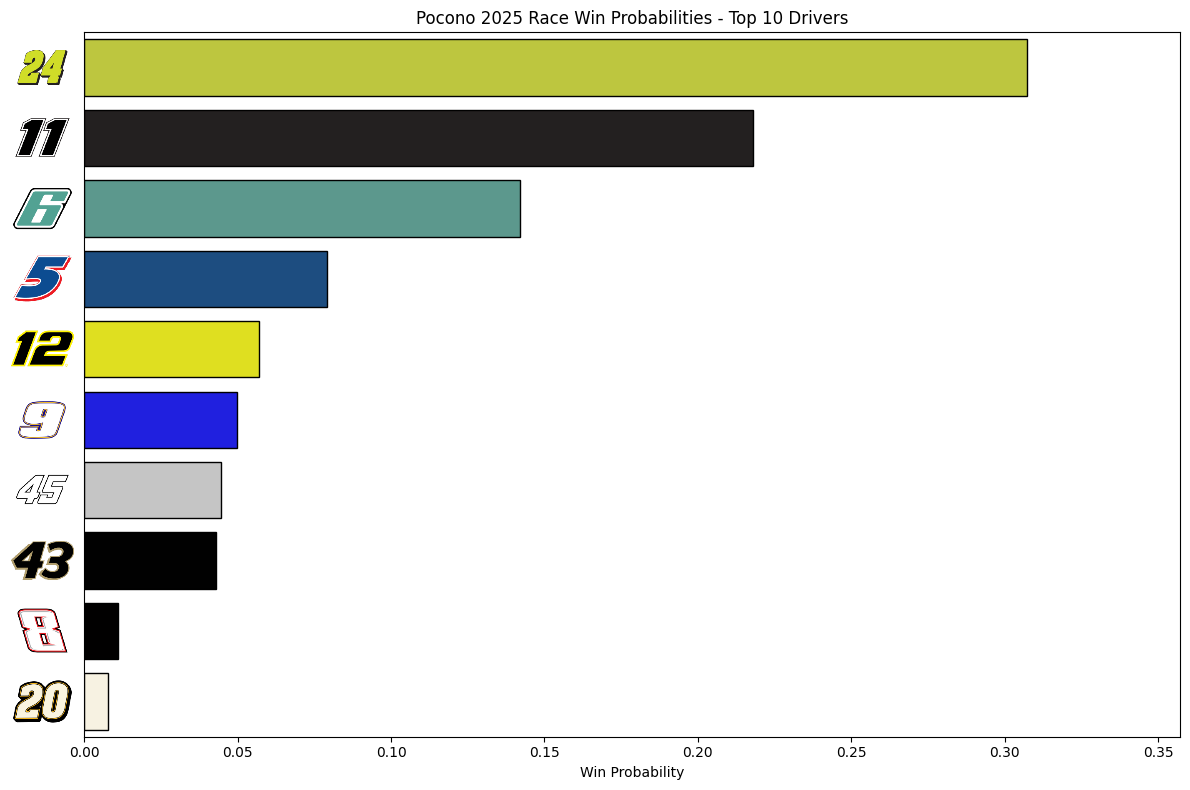

In [36]:
# define colors from driver num logo using function above 
bar_colors = []

for idx, row in top_10.iterrows():
    img_url = f"https://raw.githubusercontent.com/jake-lukasik/NASCAR-Race-Predictions/main/Driver-Num-Logos/{row['Car No.']}.png"
    col = get_main_hex_color(img_url)
    bar_colors.append(col)

plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data=top_10,
    x='Win_Prob',
    y='Driver',
    hue='Driver',
    palette=bar_colors,
    dodge=False,
    legend=False
) # bunch of extra commands to dodge FutureWarning

# add black outline
for bar in barplot.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1)

plt.yticks([])

plt.xlabel('Win Probability')
plt.ylabel('')
plt.title('Pocono 2025 Race Win Probabilities - Top 10 Drivers')
plt.xlim(0, top_10['Win_Prob'].max() + 0.05)

# Add car number images
for i, car_num in enumerate(top_10['Car No.']):
    #Old logic when images were local; swapped out b/c GitHub storage
    #img_path = f"https://raw.githubusercontent.com/jake-lukasik/NASCAR-Race-Predictions/main/Driver-Num-Logos/{car_num}.png"
    #image = plt.imread(img_path)
    response = requests.get(f"https://raw.githubusercontent.com/jake-lukasik/NASCAR-Race-Predictions/main/Driver-Num-Logos/{car_num}.png")
    image = Image.open(BytesIO(response.content))
    im = OffsetImage(image, zoom=0.3)
    ab = AnnotationBbox(im, (0, i), xybox=(-30, 0), frameon=False,
                        xycoords='data', boxcoords="offset points", pad=0)
    plt.gca().add_artist(ab)

plt.tight_layout()
plt.show()